In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

Device: cpu


In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_dataset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

class_names = train_dataset_full.classes
print("Classes:", class_names)

# Train/Val split
val_size = 5000
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:

val_dataset.dataset.transform = test_transform

batch_size = 128
num_workers = 2  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))


Train batches: 352 | Val batches: 40 | Test batches: 79


In [6]:
class Cifar10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1: 3x32x32 -> 32x32x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),        # -> 32x16x16
            nn.Dropout(0.25),

            # Block 2: -> 64x16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),        # -> 64x8x8
            nn.Dropout(0.30),

            # Block 3: -> 128x8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),        # -> 128x4x4
            nn.Dropout(0.35),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # -> 128x1x1
            nn.Flatten(),                  # -> 128
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.40),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = Cifar10CNN().to(device)
print(model)



Cifar10CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d

In [7]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Early stopping
best_val_acc = 0.0
best_state = None
patience = 8
patience_counter = 0

max_epochs = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(1, max_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | LR {lr:.1e} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

print("Best val acc:", best_val_acc)


Epoch 01 | LR 1.0e-03 | train loss 0.4940 acc 0.8304 | val loss 0.5254 acc 0.8306
Epoch 02 | LR 1.0e-03 | train loss 0.4852 acc 0.8322 | val loss 0.4937 acc 0.8282
Epoch 03 | LR 1.0e-03 | train loss 0.4868 acc 0.8327 | val loss 0.6225 acc 0.7948
Epoch 04 | LR 1.0e-03 | train loss 0.4775 acc 0.8355 | val loss 0.5098 acc 0.8256
Epoch 05 | LR 5.0e-04 | train loss 0.4722 acc 0.8373 | val loss 0.4943 acc 0.8340
Epoch 06 | LR 5.0e-04 | train loss 0.4326 acc 0.8512 | val loss 0.4464 acc 0.8496
Epoch 07 | LR 5.0e-04 | train loss 0.4186 acc 0.8561 | val loss 0.4531 acc 0.8398
Epoch 08 | LR 5.0e-04 | train loss 0.4162 acc 0.8557 | val loss 0.4479 acc 0.8436
Epoch 09 | LR 5.0e-04 | train loss 0.4095 acc 0.8596 | val loss 0.4372 acc 0.8502
Epoch 10 | LR 5.0e-04 | train loss 0.4044 acc 0.8623 | val loss 0.4633 acc 0.8444
Best val acc: 0.8502


TEST  loss: 0.4645 | acc: 0.8417


/home/assmac/Desktop/Projets/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


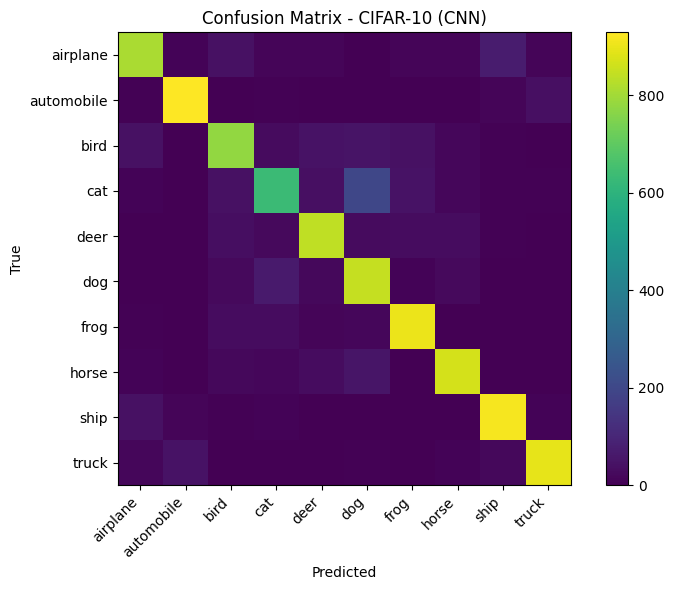

  airplane: 0.810
automobile: 0.929
      bird: 0.777
       cat: 0.633
      deer: 0.841
       dog: 0.848
      frog: 0.901
     horse: 0.869
      ship: 0.915
     truck: 0.894


In [11]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"TEST  loss: {test_loss:.4f} | acc: {test_acc:.4f}")


import matplotlib.pyplot as plt

@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_preds = []
    all_true = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())
    return np.concatenate(all_true), np.concatenate(all_preds)

y_true, y_pred = get_preds(model, test_loader)

cm = np.zeros((10, 10), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - CIFAR-10 (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, name in enumerate(class_names):
    print(f"{name:>10s}: {per_class_acc[i]:.3f}")